In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection, ensemble, linear_model
from soyviz import plot_los_tres
import matplotlib.pyplot as plt

In [2]:
condicion = pd.read_parquet('condicion.parquet')
sra = pd.read_csv('sra.csv')

In [3]:
X = pd.read_parquet('combat.parquet')
y = condicion['estres']

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=5)

## Linear

In [5]:
# alfas, coefs, _ = linear_model.lasso_path(X_train, y_train, eps=0.5)
# for coef in coefs:
#     plt.plot(alfas, coef)

In [6]:
# linear = linear_model.LassoCV(eps = 0.25, verbose = True, n_jobs=-1)
# linear.fit(X_train, y_train)
# linear.alpha_

In [7]:
# plt.semilogx(np.flip(np.sort(np.abs(linear.coef_))))
# plt.title('Coeficientes ordenados por magnitud (lasso)')

In [8]:
# (np.abs(linear.coef_) > 0.0015).sum()

In [9]:
# X_tsne = tsne.fit_transform(X.loc[:, np.abs(linear.coef_) > 0.0015])
# plot_los_tres(X_tsne, condicion, sra)
# plt.suptitle('t-SNE expresión de genes seleccionados')

## Random Forest

In [10]:
random_forest = ensemble.RandomForestClassifier()
params = {
    'n_estimators': np.arange(100, 1000, 100),
    'max_depth': np.arange(20, 50, 10),
    'min_samples_split': np.arange(2, 15, 4),
    'min_samples_leaf': np.arange(2, 15, 4),
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

In [11]:
search = model_selection.RandomizedSearchCV(estimator=random_forest, param_distributions=params, n_jobs=-1, scoring='roc_auc_ovr')
search.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': array([20, 30, 40]),
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': array([ 2,  6, 10, 14]),
                                        'min_samples_split': array([ 2,  6, 10, 14]),
                                        'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900])},
                   scoring='roc_auc_ovr')

In [12]:
search.cv_results_['mean_test_score'].mean()

0.9753653602309464

/home/godo/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "/home/godo/.local/lib/python3.10/site-packages/sklea

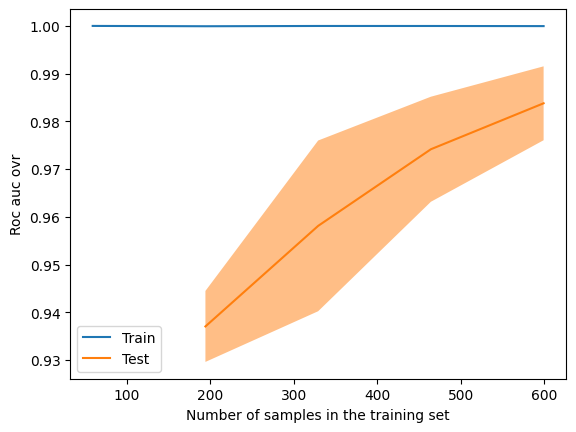

In [13]:
estimator = search.best_estimator_
model_selection.LearningCurveDisplay.from_estimator(estimator, X_train, y_train, scoring='roc_auc_ovr')

In [14]:
importances = pd.DataFrame({'importance': np.flip(np.sort(estimator.feature_importances_))}, index=X_train.columns[np.flip(estimator.feature_importances_.argsort())])
importances

,importance
Gene,
Glyma.14G180900,0.004128
Glyma.18G263000,0.003686
Glyma.15G005232,0.003396
Glyma.13G312650,0.003289
Glyma.15G145800,0.003176
...,...
Glyma.13G184700,0.000000
Glyma.13G184600,0.000000
Glyma.13G184550,0.000000


Text(0.5, 1.0, 'Importancias de features ordenadas (Random Forest)')

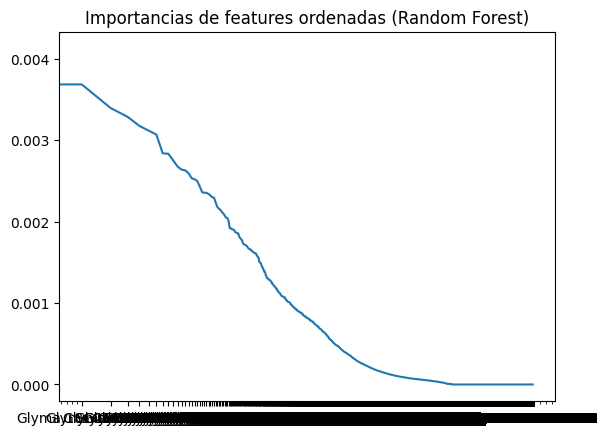

In [15]:
importances = pd.DataFrame({'importance': np.flip(np.sort(estimator.feature_importances_))}, index=X_train.columns[np.flip(estimator.feature_importances_.argsort())])
plt.semilogx(importances['importance'])
plt.title('Importancias de features ordenadas (Random Forest)')

In [21]:
importances.to_csv('importancias_rf.csv')

Text(0.5, 0.98, 't-SNE expresión de genes seleccionados')

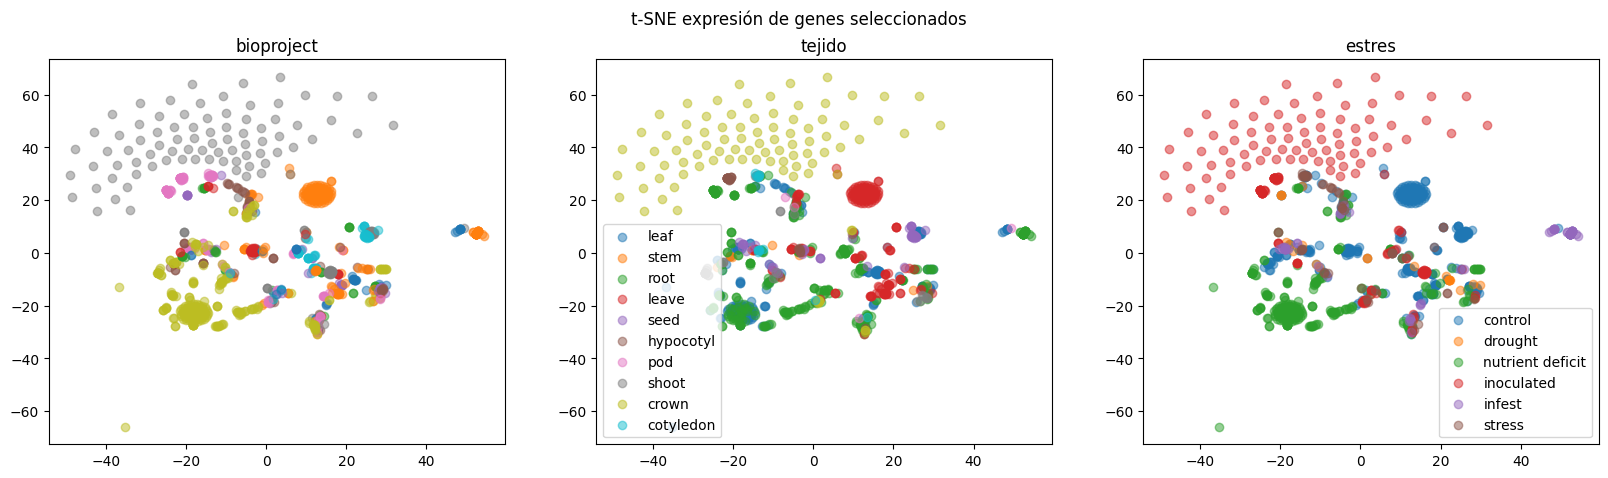

In [16]:
plot_los_tres(X.loc[:, estimator.feature_importances_ > 0.0025], condicion, sra)
plt.suptitle('t-SNE expresión de genes seleccionados')

## Gradient Boosting

In [17]:
gbr = ensemble.GradientBoostingClassifier()
params = {
    "loss": ['log_loss'],
    "learning_rate": np.arange(0, 10, 1),
    "n_estimators": np.arange(1, 200, 1),
    "max_depth": np.arange(1, 50, 1),
    "max_features": ['sqrt', 'log2']
}

In [18]:
search = model_selection.RandomizedSearchCV(gbr, param_distributions=params, n_jobs=-1, scoring='roc_auc_ovr')
search.fit(X_train, y_train)

RandomizedSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'loss': ['log_loss'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'max_features': ['sqrt', 'log2'],
                                        'n_est...
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199])},
                   scoring='roc_auc_ovr')

In [19]:
search.cv_results_['mean_test_score'].mean()

0.804227764740363

/home/godo/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "/home/godo/.local/lib/python3.10/site-packages/sklea

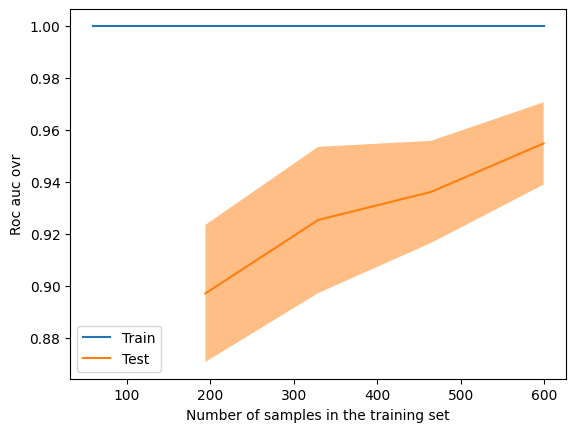

In [20]:
model_selection.LearningCurveDisplay.from_estimator(search.best_estimator_, X_train, y_train, scoring='roc_auc_ovr')